In [1]:
import seaborn as sns
from pathlib import Path
from natsort import natsorted

import yaml
import shutil

import numpy as np

import pandas as pd


In [2]:
# Settings and Variables

# This Experiment (= Model and Parameter Configuration
from yaml.constructor import ConstructorError
_ROOT = Path('..')
out_path = Path('..') / Path('output')
_model_name = 'VisualTransformer'
_dataset_name = 'PrimatesLibrosaDatamodule'
breakpoint()
_param_name = 'heads'

In [3]:
def print_stats(data_option, mean_duration, std_duration, min_duration, max_duration, dataset=None):
    if dataset is not None:
        print(f'For {data_option}; dataset is: {dataset}')
    print(f'For {data_option}; statistics are:')
    print(f'Scores - mean: {mean_duration:.3f}s\tstd: {std_duration:.3f}s '
          f'min: {min_duration:.3f}s\t max: {max_duration:.3f}s')

def is_clean(exp_path: Path):
    if exp_path.exists():
        runs = list(exp_path.iterdir())

        if len(runs) <= 3:
            shutil.rmtree(exp_path)
            return False

        else:
            return True
    else:
        return False

def print_metrics(exp_path, valid_dataset_name=None):
    best_scores = []
    had_errors = []
    dataset_name = None
    header_printed = False
    for idx, run_folder in enumerate([x for x in exp_path.iterdir() if x.is_dir()]):
        # model_class = locate_and_import_class(model_name, 'models')
        # sorted_checkpoints = natsorted(run_folder.glob('*.ckpt'))
        # model = ModelIO.load_from_checkpoint(str(sorted_checkpoints[0]), strict=True)
        try:
            yaml_file = run_folder / 'hparams.yaml'
            if dataset_name is None and yaml_file.exists():
                with yaml_file.open('rb') as f:
                    configuration = yaml.load(f, yaml.BaseLoader)
                    dataset_name = configuration['data_name']

        except IOError:
            pass

        try:
            if dataset_name != valid_dataset_name and valid_dataset_name is not None:
                raise NameError
            metrics: pd.DataFrame = pd.read_csv(run_folder / 'metrics.csv')
           # Possible keys are:
            # -- CE - Losses:
            # val_max_vote_loss, val_mean_vote_loss, mean_val_loss
            # -- Fallback:
            # mean_loss,epoch,step,macro_f1_score, macro_roc_auc_ovr, uar_score, micro_f1_score
            # Pytorch Metrics:
            # PL_f1_score,PL_accuracy_score_score, PL_fbeta_score,PL_recall_score,PL_precision_score,
            score = metrics.PL_recall_score.max()
            epoch = metrics.PL_recall_score.argmax()
            if not header_printed:
                print(f'--------------{exp_path.name}------------------')
                header_printed=True
            print(f'{exp_path.name} - {run_folder.name}: {score}, epoch: {epoch / 5}')
            best_scores.append(score)
            had_errors.append(False)
        except (AttributeError, FileNotFoundError, NameError):
            had_errors.append(True)
            pass
    if any(had_errors) or (dataset_name is None and valid_dataset_name is not None):
        print('-------------- Had Errors ------------------')
        return
    else:
        print('\n')
        stats = np.nanmean(best_scores), np.nanstd(best_scores), np.nanmin(best_scores), np.nanmax(best_scores)
        print_stats(exp_path.name, *stats, dataset=dataset_name)
        print('--------------------------------------------')


In [4]:
for model_configuration in natsorted([x for x in (out_path / _model_name).iterdir() if x.is_dir()]):
    # Print metrics
    if is_clean(model_configuration):
        print_metrics(model_configuration, valid_dataset_name=_dataset_name)
print('--------------------END------------------------')


--------------VT_01123c93daaffa92d2ed341bda32426d------------------
VT_01123c93daaffa92d2ed341bda32426d - version_0: 0.8587360978126526, epoch: 86.0
VT_01123c93daaffa92d2ed341bda32426d - version_1: 0.8587360978126526, epoch: 86.0
VT_01123c93daaffa92d2ed341bda32426d - version_2: 0.8587360978126526, epoch: 86.0
VT_01123c93daaffa92d2ed341bda32426d - version_3: 0.8587360978126526, epoch: 86.0
VT_01123c93daaffa92d2ed341bda32426d - version_4: 0.8504778146743774, epoch: 58.0


For VT_01123c93daaffa92d2ed341bda32426d; dataset is: PrimatesLibrosaDatamodule
For VT_01123c93daaffa92d2ed341bda32426d; statistics are:
Scores - mean: 0.857s	std: 0.003s min: 0.850s	 max: 0.859s
--------------------------------------------
--------------VT_012aff7c1c667073aedafcbebfa35ec7------------------
VT_012aff7c1c667073aedafcbebfa35ec7 - version_0: 0.8631429672241211, epoch: 79.8
VT_012aff7c1c667073aedafcbebfa35ec7 - version_1: 0.864475429058075, epoch: 58.0
VT_012aff7c1c667073aedafcbebfa35ec7 - version_2: 0.86831

In [5]:
if False:
    # fingerprint = '012aff7c1c667073aedafcbebfa35ec7'
    fingerprint = 'fdf2a86085b508c1325b181c830a4cf7'
    exp_name = f'{"".join([x for x in model_name if x.isupper()])}_{fingerprint}'

    # Print metrics
    print_metrics(out_path/model_name/exp_name)

In [6]:
if False:
    predictions_file = out_path/model_name/'VT_fbbe1be4393718c3be98f9ff5f6822fa'/'version_9'/'predictions.csv'
    df_predictions = pd.read_csv(predictions_file)
    print(df_predictions.head())
    # df_predictions = df_predictions[['filenames', 'prediction_named']]
    # df_predictions.columns = ['filename', 'prediction']
    df_predictions['filename']: pd.DataFrame = df_predictions['filename'].str.replace('npy', 'wav')
    predictions_file_new = predictions_file.parent / 'prediction_final.csv'
    df_predictions.to_csv(index=False, path_or_buf=predictions_file_new)


In [7]:
def single_params_score_readout(exp_folder, param_name, monitor='PL_recall_score'):
    scores = list()
    param_readout = None
    for run_folder in [x for x in exp_folder.iterdir() if x.is_dir()]:
        yaml_file = run_folder / 'hparams.yaml'
        with yaml_file.open('rb') as f:
            configuration = yaml.load(f, yaml.BaseLoader)
            if param_readout is None:
                param_readout = configuration[param_name]
            else:
                if param_readout != configuration[param_name]:
                    raise ValueError
            metrics: pd.DataFrame = pd.read_csv(run_folder / 'metrics.csv')
            # Possible keys are:
            # -- CE - Losses:
            # val_max_vote_loss, val_mean_vote_loss, mean_val_loss
            # -- Fallback:
            # mean_loss,epoch,step,macro_f1_score, macro_roc_auc_ovr, uar_score, micro_f1_score
            # Pytorch Metrics:
            # PL_f1_score,PL_accuracy_score_score, PL_fbeta_score,PL_recall_score,PL_precision_score,
            monitor_score=metrics[monitor].max()

            scores.append(monitor_score)
    return dict(mean=np.mean(scores), max=np.max(scores), std=np.std(scores), param_readout=param_readout)


if True:
    scores_for_param = list()
    for modelname in ['VisualTransformer', 'VerticalVisualTransformer']:
        for model_configuration in natsorted([x for x in (out_path / modelname).iterdir() if x.is_dir()]):
            # Print metrics
            if is_clean(model_configuration):
                score_for_param=single_params_score_readout(model_configuration, _param_name)
                score_for_param.update(modelname=modelname)
                scores_for_param.append(score_for_param)

        df = pd.DataFrame(scores_for_param)

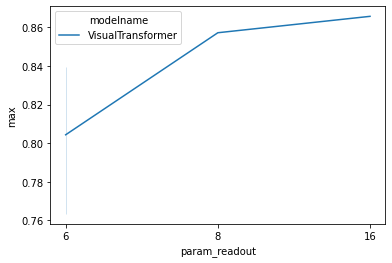

In [8]:
lineplot = sns.lineplot(data=df, x='param_readout', y='max', hue='modelname', legend=True)